#Evolutionary computing: lab1

The problem is to adjust parameters of evolutionary algorithm to find an optimum of Rastrigin function with following conditions:
+ Dimension of the problem: 100
+ Populatin size: 100
+ Minimum value of found extremum: 9.5 (the best is 10)

In [1]:
# we will use DEAP framework
!pip install deap

     |████████████████████████████████| 160 kB 6.8 MB/s 


Here we describe Rastrigin Function:


In [2]:
import numpy as np
import math

def rastrigin(individual):
    n = len(individual)
    pi = math.pi
    dn = 1.0 / n
    a = 10.0
    b = 0.2
    c = 2 * pi
    s1 = 0.0
    s2 = 0.0
    for i in range(n):
        s1 += individual[i] * individual[i]
        s2 += np.cos(c*individual[i])
    s1 = -a * math.exp(-b*math.sqrt(dn*s1))
    s2 = -math.exp(dn*s2)
    result = s1+s2 + a + math.exp(1)
    result = -result
    result = result + a
    result = math.fabs(result)
    return result

Here we describe eaMuPlusLambda algorithm (mu - population size, lambda - number of individuals after crossover, the next generation is formed both from new individuals and old ones):

In [3]:
def varOr(population, toolbox, lambda_, cxpb, mutpb):
    offspring = []
    for _ in range(lambda_):
        op_choice = random.random()
        if op_choice < cxpb:            # Apply crossover
            ind1, ind2 = list(map(toolbox.clone, random.sample(population, 2)))
            ind1, ind2 = toolbox.mate(ind1, ind2)
            del ind1.fitness.values
            del ind2.fitness.values
            offspring.append(ind1)
        elif op_choice < cxpb + mutpb:  # Apply mutation
            ind = toolbox.clone(random.choice(population))
            ind, = toolbox.mutate(ind)
            del ind.fitness.values
            offspring.append(ind)
        else:                           # Apply reproduction
            offspring.append(toolbox.clone(random.choice(population)))

    return offspring

In [4]:
import operator
import random

def eaMuPlusLambda(population, toolbox, mu, lambda_, cxpb, mutpb, ngen,
                   stats=None, halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = (fit, )
    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Vary the population
        if halloffame is not None:
            for ind in halloffame:
                population.append(toolbox.clone(ind))
        offspring = varOr(population, toolbox, lambda_, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = (fit, )

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Select the next generation population
        population[:] = toolbox.select(population + offspring, mu)

        # Update the statistics with the new population
        if not gen%10:
          record = stats.compile(population) if stats is not None else {}
          logbook.record(gen=gen, nevals=len(invalid_ind), **record)
          if verbose:
              print(logbook.stream)

    return population, logbook

Here we create a class for execution of simple experiment, it contains parameteres of evolutionary algorithm which we need to fix in oder to get better perfomance:

In [5]:
def mutation(individual):
    n = len(individual)
    for i in range(n):
        if rnd.random() < n * 0.15:
            individual[i] += rnd.normal(0.0, 0.2)
            individual[i] = np.clip(individual[i], -5, 5)
    return individual,

In [6]:
from deap import tools
from numpy import random as rnd

class SimpleGAExperiment:
    def factory(self):
        return rnd.random(self.dimension) * 10 - 5

    def __init__(self, function, dimension, pop_size, iterations):
        self.pop_size = pop_size
        self.iterations = iterations
        self.mut_prob = 0.6
        self.cross_prob = 0.3

        self.function = function
        self.dimension = dimension

        self.engine = base.Toolbox()
        self.engine.register("map", map)
        self.engine.register("individual", tools.initIterate, creator.Individual, self.factory)
        self.engine.register("population", tools.initRepeat, list, self.engine.individual, self.pop_size)
        self.engine.register("mate", tools.cxOnePoint)
        self.engine.register("mutate", mutation)
        self.engine.register("select", tools.selTournament, tournsize=4)
        self.engine.register("evaluate", self.function)
        self.best = None
        self.best_fit = None


    def run(self, update_log = 'yes'):
        pop = self.engine.population()
        hof = tools.HallOfFame(3, np.array_equal)
        stats = tools.Statistics(lambda ind: ind.fitness.values[0])
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)
        pop, log = eaMuPlusLambda(pop, self.engine, mu=self.pop_size, lambda_=int(self.pop_size*0.8), cxpb=self.cross_prob, mutpb=self.mut_prob,
                                  ngen=self.iterations,
                                  stats=stats, halloffame=hof, verbose=True if update_log == 'yes' else False)
        
        if update_log == 'yes':
          print("Best = {}".format(hof[0]))
          print("Best fit = {}".format(hof[0].fitness.values[0]))
        
        self.best = hof[0]
        self.best_fit = hof[0].fitness.values[0]
        return log

Here we need to create the Fitness and the Individual classes:

In [7]:
from deap import creator
from deap import base
creator.create("BaseFitness", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.BaseFitness)

Let's execute the experiment with basic parameters:

In [8]:
dimension = 100
pop_size = 100
iterations = 100
scenario = SimpleGAExperiment(rastrigin, dimension, pop_size, iterations)
log = scenario.run()

gen	nevals	avg    	std     	min    	max    
0  	100   	3.88306	0.166921	3.55744	4.35602
10 	70    	4.73043	0.0332824	4.56592	4.86373
20 	71    	5.01326	0.0305611	4.86543	5.06822
30 	73    	5.11061	0.0260016	4.88332	5.21739
40 	75    	5.24383	0.0314159	4.93242	5.25348
50 	73    	5.25688	1.77636e-15	5.25688	5.25688
60 	74    	5.25538	0.014979   	5.10634	5.25688
70 	74    	5.25688	1.77636e-15	5.25688	5.25688
80 	66    	5.25688	1.77636e-15	5.25688	5.25688
90 	75    	5.25688	1.77636e-15	5.25688	5.25688
100	68    	5.25302	0.0384385  	4.87056	5.25688
Best = [ 0.71139906 -1.90260878 -0.73496897 -1.04125224 -1.89053557 -0.17000902
  0.09782595  2.14817306  1.81572158 -1.86140927 -0.43742451  0.93300551
 -2.29355714  1.09917906 -0.14799723  0.1280856   2.91380589 -1.82670784
  3.95315032 -1.98342552  2.10372911  2.12484366 -2.18738603 -2.82470473
  3.29032813 -0.98060703 -3.09701782  2.573814   -3.15032506  2.84662698
  2.80968181  1.17382503 -3.89475737  1.38585595 -1.01916075 -2.9476173
  1.02

After 100 generations we can see that std parameter is almost zero and muations range is not wide enough, to improve this let's change some parameters:

In [22]:
# we have a lot of local optimums, let's set a large probability of mutation to avoid stucking
scenario.mut_prob = 0.9
# it was found empirically that mutShuffleIndexes mutation allows to find individuals close to the optimum quickly
# mutFlipBit is also a good option, but it stucks around values close to 9.5
scenario.engine.register("mutate", tools.mutShuffleIndexes, indpb=0.9)
# we use low probability of crossover to have a large variety of individuals
scenario.cross_prob = 0.1

In [24]:
scenario.iterations = 200
log = scenario.run()

gen	nevals	avg    	std     	min    	max    
0  	100   	3.92602	0.163168	3.56662	4.39822
10 	80    	4.74388	0.0504723	4.61805	4.77802
20 	80    	5.46455	0.0452778	5.38005	5.52931
30 	80    	6.29917	0.107608 	6.02573	6.56563
40 	80    	6.9194 	0.0244258	6.90455	6.96296
50 	80    	7.29282	0.0172119	7.26977	7.34374
60 	80    	7.63442	0.0559315	7.55274	7.72361
70 	80    	8.05841	0.0306512	7.95931	8.13722
80 	80    	8.27015	0.0335   	8.20695	8.32517
90 	80    	8.48712	0.0169772	8.47845	8.52106
100	80    	8.71135	0.0145748	8.68815	8.79336
110	80    	9.01342	0.025579 	8.95161	9.06836
120	80    	9.27096	0.0261339	9.20188	9.32725
130	80    	9.59393	0.0600722	9.54156	9.67695
140	80    	9.859  	0.00722826	9.81886	9.8644 
150	80    	9.93647	0.00881135	9.92573	9.95263
160	80    	9.96886	0.00022908	9.96853	9.9693 
170	80    	9.97008	1.77636e-15	9.97008	9.97008
180	80    	9.97008	1.77636e-15	9.97008	9.97008
190	80    	9.97008	1.77636e-15	9.97008	9.97008
200	80    	9.97008	1.77636e-15	9.97008	9.97008
B

We found a good result almost immediately in 200 iterations, let's check how often we can have this result:

In [25]:
tries = 100
best_fit = []
for i in range(tries):
  log = scenario.run(update_log = 'no')
  best_fit.append(scenario.best_fit)
  if not (i+1)%10:
    print(f'{i+1} iterations are ready')

10 iterations are ready
20 iterations are ready
30 iterations are ready
40 iterations are ready
50 iterations are ready
60 iterations are ready
70 iterations are ready
80 iterations are ready
90 iterations are ready
100 iterations are ready


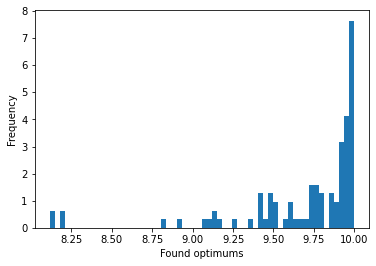

In [29]:
import matplotlib.pyplot as plt

plt.hist(best_fit, density=True, bins = 60)
plt.ylabel('Frequency')
plt.xlabel('Found optimums');

In [30]:
percent = sum(i >= 9.5 for i in best_fit)/len(best_fit)
print('Percentage of values that are equal or more than 9.5 =', percent)

Percentage of values that are equal or more than 9.5 = 0.77


As a result we can see that in the majority of cases we are able to find an optimum > 9.5 just in 200 iteratinons by applying following changes:
+ scenario.mut_prob = 0.9
+ scenario.engine.register("mutate", tools.mutShuffleIndexes, indpb=0.9)
+ scenario.cross_prob = 0.1